In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
sim_pccomp = pd.read_csv(
    "/home/peter/Documents/uni/FIN-Dataset/hallway/pccomp/metrics/pccomp-hallway-sim.csv"
    
)
sim_draco = pd.read_csv(
    "/home/peter/Documents/uni/FIN-Dataset/hallway/draco/metrics/draco-hallway-sim.csv"
)

In [10]:
metrics_df = pd.read_csv(
    # "/home/peter/Documents/uni/FIN-Dataset/hallway/draco/metrics/draco-hallway.csv"
    "/home/peter/Documents/uni/FIN-Dataset/hallway/pccomp/metrics/pccomp-hallway.csv"
    
)
metrics_draco = pd.read_csv(
    "/home/peter/Documents/uni/FIN-Dataset/hallway/draco/metrics/draco-hallway.csv"    
)

In [11]:
metrics_df["Symmetric Similarity"] = sim_pccomp["Symmetric Similarity"]
metrics_draco["Symmetric Similarity"] = sim_draco["Symmetric Similarity"]

In [12]:
metrics_df

,bpp,enc_file_size_bits,time_dec_ns,time_enc_ns,file,num_points,Symmetric Similarity
0,53.259259,5752,838047,3882568,T0-108.ply,108,0.901232
1,30.109091,9936,484993,618705,T1-330.ply,330,0.973187
2,23.613876,15656,507862,557110,T2-663.ply,663,0.998859
3,16.481928,106704,1210729,1664122,T3-6474.ply,6474,0.995168
4,15.808275,231528,2345822,3492718,T4-14646.ply,14646,0.995156
...,...,...,...,...,...,...,...
164,12.713146,11350144,114459628,154282656,T164-892788.ply,892788,0.995178
165,12.709717,11396536,116053556,156198921,T165-896679.ply,896679,0.995175
166,12.706886,11493760,113681440,158588871,T166-904530.ply,904530,0.995172
167,12.703395,11543880,117197033,157380551,T167-908724.ply,908724,0.995182


In [13]:
metrics_draco

,file,bpp,enc_file_size_bits,time_dec_ns,num_points,time_enc_ns,Symmetric Similarity
0,T0-108.ply,32.148148,3472,3203166,108,2268848,0.999055
1,T1-330.ply,14.206061,4688,6778865,330,5379192,0.997570
2,T2-663.ply,11.028658,7312,6827248,663,7456942,0.995373
3,T3-6474.ply,6.921223,44808,8584859,6474,12372344,0.985614
4,T4-14646.ply,5.857162,85784,10131603,14646,16662570,0.972539
...,...,...,...,...,...,...,...
164,T164-892788.ply,3.053446,2726080,144703536,892788,247235653,0.843523
165,T165-896679.ply,3.043114,2728696,129159396,896679,150960756,0.843524
166,T166-904530.ply,3.045471,2754720,36834492,904530,254789230,0.843821
167,T167-908724.ply,3.060115,2780800,143336002,908724,111849892,0.843941


In [34]:
bpps = metrics_df["bpp"]
enc_size = metrics_df["enc_file_size_bits"]/8000
time_enc = metrics_df["time_enc_ns"]/10**9
time_dec = metrics_df["time_dec_ns"]/10**9
points = metrics_df["num_points"]
similarity = metrics_df["Symmetric Similarity"]
x = np.arange(metrics_df.index.size)

draco_bpps = metrics_draco["bpp"]
draco_enc_size = metrics_draco["enc_file_size_bits"]/8000
draco_time_enc = metrics_draco["time_enc_ns"]/10**9
draco_time_dec = metrics_draco["time_dec_ns"]/10**9
draco_points = metrics_draco["num_points"]
draco_similarity = metrics_draco["Symmetric Similarity"]

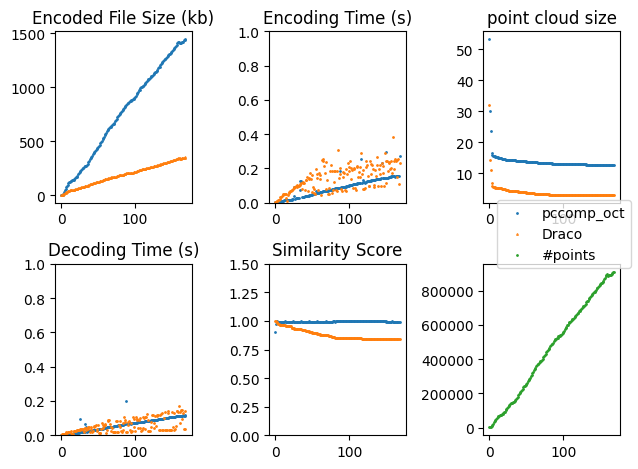

In [45]:
fig, axs = plt.subplots(2,3)

l1 = axs[0, 0].scatter(x, enc_size, s=1)
l2 = axs[0, 0].scatter(x, draco_enc_size, s=1, marker='^')
axs[0, 0].set_title("Encoded File Size (kb)")
axs[0, 1].scatter(x, time_enc, s=1)
axs[0, 1].scatter(x, draco_time_enc, s=1)
axs[0, 1].set_title("Encoding Time (s)")
axs[1, 0].scatter(x, time_dec, s=1)
axs[1, 0].scatter(x, draco_time_dec, s=1)
axs[1, 0].set_title("Decoding Time (s)")
axs[1, 1].scatter(x, similarity, s=1)
axs[1, 1].scatter(x, draco_similarity, s=1)
axs[1, 1].set_title("Similarity Score")
axs[0, 2].scatter(x, bpps, s=1)
axs[0, 2].scatter(x, draco_bpps, s=1)
axs[0, 2].set_title("Bits per Point")
l3 = axs[1, 2].scatter(x, points, s=1, color="tab:green")
axs[1, 2].set_title("point cloud size")
axs[1, 1].set_ylim([0, 1.5])
axs[0, 1].set_ylim([0, 1])
axs[1, 0].set_ylim([0, 1])

fig.legend([l1, l2, l3], ["pccomp_oct", "Draco", "#points"], loc="center right")
fig.tight_layout()